In [1]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from tqdm import tqdm
from matplotlib.animation import FuncAnimation, FFMpegFileWriter

In [2]:
mooring_shelfExtended_kogur = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_kogur.nc')
mooring_north = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_north_new.nc')
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(66,77)).sel(X=slice(-30,10))
depth_no_nan = depth

df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Background_var.nc')

In [3]:
# Due to changes from 78.5N to 76N for the northern boundary, the lenght needs to be fixed

pos_Extended = []
for mooring in mooring_shelfExtended['mooring']:
    if mooring_shelfExtended.YC[mooring][0][0] > 75.992 and mooring_shelfExtended.YC[mooring][0][0] < 76.008:
        # print(mooring.values)
        pos_Extended.append(mooring.values)


pos_north = []
for mooring in mooring_north['mooring']:
    test = depth_no_nan.sel(X=mooring_north.XC[mooring][0][0].values).sel(Y=mooring_north.YC[mooring][0][0].values).values
    if test <= 0:
        pos_north.append(mooring.values)

In [4]:
# Defining the interior domain based on the defined boundaries

cond = mooring_north ==  mooring_north.XC <= mooring_shelfExtended.XC[pos_Extended[-1]][0][0].values
mooring_north = mooring_north.where(cond,drop=True)

mooring_north = mooring_north.sel(mooring=slice(23,mooring_north.mooring[-1].values))

mooring_shelfExtended = mooring_shelfExtended.sel(mooring=slice(pos_Extended[-1],mooring_shelfExtended.mooring[-1].values))
display(mooring_shelfExtended)

XC_north = [mooring_north["XC"][x-23].values[0][0] for x in mooring_north['mooring']]
YC_north = [mooring_north["YC"][x-23].values[0][0] for x in mooring_north['mooring']]

XC_east1 = [mooring_shelfExtended["XC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
YC_east1 = [mooring_shelfExtended["YC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
XC_east2 = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC_east2 = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]

XC_south = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC_south = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]

<xarray.Dataset>
Dimensions:            (Z: 216, Zp1: 217, Zu: 216, Zl: 216, mooring: 938, Y: 1,
                        X: 1, Yp1: 2, Xp1: 2, time: 1460, time_midp: 1459,
                        mooring_midp: 1053)
Coordinates: (12/29)
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * Zp1                (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu                 (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl                 (Zl) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03
    drF                (Z) float64 ...
    XC                 (mooring, Y, X) float64 ...
    ...                 ...
  * Y                  (Y) int64 0
  * Xp1                (Xp1) int64 0 1
  * Yp1                (Yp1) int64 0 1
    mooring_dist       (mooring) float64 ...
  * mooring_midp       (mooring_midp) float64 0.5 1.5 ... 1.052e+03 1.052e+03
    mooring_midp_dist  (mooring_midp) float64 ...
Data variables:
    U                  (time, Z, mooring, Y, Xp1) float64 ...
    V                  (time, Z, mooring, Yp1, X) float64 ...
    Temp               (time, Z, mooring, Y, X) float64 ...
    S                  (time, Z, mooring, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [43]:
def Transport(mooringDataset=xr.Dataset):
    # Open dataset as OceanDataset
    od = ospy.OceanDataset(mooringDataset)
    # Subsample into monthly mean values
    od = od.subsample.cutout(timeFreq='D',sampMethod='mean')
    # Compute total transport through the mooring array
    od = od.compute.mooring_volume_transport()

    # Defining salinity integration depth
    transport = od.dataset['transport']
    
    return transport

try:
    kogur = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/VT/kogur_VT.nc')['transport']
except:
    kogur = Transport(mooring_kogur)
    kogur.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/VT/kogur_VT.nc')
try:
    north = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/VT/north_VT.nc')['transport']
except:
    mooring_north = mooring_north.drop_vars(names=['transport','Vtransport','Utransport','Y_transport','X_transport','Y_Utransport','X_Utransport','Y_Vtransport','X_Vtransport','dir_Utransport','dir_Vtransport'])
    north = Transport(mooring_north)
    north.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/VT/north_VT.nc')
try:
    SB_1 = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/VT/SB_1_VT.nc')['transport']
except:
    SB_1 = Transport(mooring_shelfExtended)
    SB_1.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/VT/SB_1_VT.nc')

try:
    SB_2 = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/VT/SB_2_VT.nc')['transport']
except:
    SB_2 = Transport(mooring_shelfExtended_kogur)
    SB_2.to_netcdf('/nird/projects/NS9608K/MSc_EK/Data/VT/SB_2_VT.nc')

try:
    del mooring_kogur, mooring_north, mooring_shelfExtended, mooring_shelfExtended_kogur
except:
    pass

In [44]:
north = north.mean(dim='path').isel(X=0,Y=0).mean(dim='time').sum(dim='Z')
kogur = kogur.mean(dim='path').sum(dim='Z').mean(dim='time')
SB_1 = SB_1.mean(dim='path').sum(dim='Z').mean(dim='time')
SB_2 = SB_2.mean(dim='path').sum(dim='Z').mean(dim='time')

In [45]:
display(kogur,north)

<xarray.DataArray 'transport' (mooring: 199)>
array([ 0.        , -0.0104972 , -0.01234521, -0.00805997, -0.00518687,
       -0.00783876, -0.00567721, -0.01762977, -0.0063941 , -0.00417332,
       -0.00282954, -0.00251565, -0.03176771, -0.00641294, -0.00476426,
       -0.03196073, -0.00033904,  0.00504308, -0.02628496,  0.00803605,
        0.00783819, -0.02028777, -0.01135151,  0.0090994 ,  0.007233  ,
        0.00554422, -0.00025399, -0.01757756, -0.00264516, -0.00737432,
       -0.01824685, -0.0135963 , -0.01104305, -0.01654911, -0.01591358,
       -0.022266  , -0.03166246, -0.02361783, -0.03787637, -0.03981057,
       -0.02629561, -0.02996749, -0.03701552, -0.03839566, -0.04041472,
       -0.04249798, -0.02240068, -0.04073318, -0.04170538, -0.03886682,
       -0.04458695, -0.02200749, -0.04373823, -0.04717294, -0.01977232,
       -0.0463782 , -0.05087095, -0.02022422, -0.05155444, -0.05218964,
       -0.02317823, -0.02175583, -0.05842852, -0.06870984, -0.07182136,
       -0.08033713, -0.04646606, -0.08386953, -0.07814514, -0.05002027,
       -0.04445744, -0.09127276, -0.10314634, -0.10132698, -0.10631762,
       -0.05927362, -0.10332549, -0.10647241, -0.04735456, -0.03878986,
       -0.10006102, -0.092546  , -0.0853215 , -0.06935549, -0.02598773,
       -0.05765481, -0.04819638, -0.04289503, -0.04152714,  0.00423487,
       -0.0271924 , -0.01957815,  0.01348999, -0.01420104, -0.02014024,
        0.01040786, -0.02674587, -0.02412986,  0.00144653,  0.00319875,
       -0.02366091, -0.02527   , -0.0332197 , -0.03628428, -0.01817762,
       -0.04810943, -0.05261305, -0.05432673, -0.05729411, -0.05128633,
       -0.06705018, -0.07190287, -0.05568455, -0.0710638 , -0.06566122,
       -0.05420725, -0.0628854 , -0.0622231 , -0.04677045, -0.03790817,
       -0.04083277, -0.03086554, -0.03173096, -0.02124736, -0.02032337,
       -0.03535507, -0.02516377, -0.00889625, -0.00479314, -0.00115597,
        0.00055465,  0.00806059,  0.03381605,  0.0446008 ,  0.06364973,
        0.07052518,  0.07680746,  0.09199224,  0.11615373,  0.14355155,
        0.1285369 ,  0.13533854,  0.10896684,  0.11487067,  0.09270226,
        0.07189306,  0.06381449,  0.06666598,  0.06923996,  0.05154214,
        0.03455419,  0.0305635 ,  0.03527322,  0.03430137,  0.02475801,
        0.02446657,  0.00715498,  0.00357188,  0.01393001,  0.00980168,
        0.01086932, -0.0044591 , -0.00606927,  0.00610445,  0.00344215,
        0.00236567, -0.01180835, -0.00935664,  0.00059432,  0.00181272,
        0.00656063,  0.00693366,  0.01107791,  0.0138887 ,  0.01579989,
        0.021244  ,  0.01823025,  0.01596539,  0.01474699,  0.01203648,
        0.01054012,  0.00732751,  0.00535002,  0.00348829,  0.00293195,
        0.00135836,  0.00364901,  0.00229432,  0.00023264,  0.00054614,
        0.00131127,  0.00403582,  0.0024974 ,  0.00265678,  0.00372455,
        0.00256102,  0.00224588,  0.00089123,  0.        ])
Coordinates:
  * mooring       (mooring) int64 0 1 2 3 4 5 6 ... 192 193 194 195 196 197 198
    mooring_dist  (mooring) float64 ...

<xarray.DataArray 'transport' (mooring: 428)>
array([ 0.00000000e+00,  4.57953603e-04,  2.70923086e-03,  5.55092061e-03,
        7.36236367e-03,  6.25176641e-03,  6.79966083e-03,  5.64072060e-03,
        5.19820585e-03,  3.46033278e-03,  3.32276325e-03,  4.12451775e-03,
        5.78039291e-03,  4.69090632e-03,  2.51478661e-03, -3.45469320e-04,
       -3.24977604e-03, -5.65201494e-03, -1.00897726e-02, -1.10858926e-02,
       -1.26837540e-02, -9.51349479e-03, -7.22632446e-03, -3.43041400e-03,
       -7.56744758e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.26806483e-03, -1.47803595e-03,
       -1.79042794e-03, -1.82578598e-03, -2.13686549e-03, -1.82195450e-03,
       -1.87540448e-03, -1.65884277e-03, -1.68247333e-03, -1.23472817e-03,
       -9.82372002e-04, -2.68881422e-04,  1.53859558e-03,  3.78908007e-03,
        7.75366001e-03,  1.11239609e-02,  1.64297981e-02,  1.88754963e-02,
        2.56948152e-02,  2.84733426e-02,  3.83779041e-02,  4.06787324e-02,
        4.86755268e-02,  4.31481991e-02,  3.88782690e-02,  2.12474403e-02,
        1.71185287e-02,  1.51055396e-02,  1.57066189e-02,  1.26072167e-02,
        1.13399495e-02,  7.48950890e-03,  5.71657975e-03,  3.45372155e-03,
        2.78138131e-03,  1.93662064e-03,  1.58010944e-03,  1.05948199e-03,
        8.48712419e-04,  7.14273528e-04,  7.82106315e-04,  4.81673818e-04,
        3.74657486e-04,  9.39826463e-05, -1.29291614e-04, -4.60965011e-04,
       -7.57408229e-04, -1.09323740e-03, -1.14032561e-03, -6.92790723e-05,
...
       -5.62554961e-02, -5.43789615e-02, -6.08456762e-02, -5.90123403e-02,
       -6.71619293e-02, -6.19676879e-02, -6.91561776e-02, -6.33240511e-02,
       -6.87326974e-02, -6.12697516e-02, -6.48305230e-02, -5.73692426e-02,
       -5.67665447e-02, -4.79757945e-02, -4.40571244e-02, -3.57672726e-02,
       -2.79698586e-02, -2.11331747e-02, -1.16622488e-02, -6.64241515e-03,
       -6.76391828e-04,  3.46321709e-04,  4.28598801e-03, -6.85420690e-04,
       -2.05449080e-03, -8.10992038e-03, -1.09098673e-02, -2.00849144e-02,
       -3.07944309e-02, -3.76920251e-02, -4.92686666e-02, -5.38572667e-02,
       -6.49042418e-02, -5.77885726e-02, -6.28902603e-02, -5.68465049e-02,
       -6.20639248e-02, -5.53678158e-02, -5.58691948e-02, -5.18019454e-02,
       -5.37910187e-02, -5.18276847e-02, -5.96724972e-02, -5.85843341e-02,
       -6.47472897e-02, -5.94475396e-02, -5.75803822e-02, -4.70354667e-02,
       -3.97205929e-02, -2.44495502e-02, -8.53961445e-03,  1.08030424e-02,
        3.46633120e-02,  4.95574683e-02,  7.52761909e-02,  8.16670582e-02,
        1.03270317e-01,  9.97890935e-02,  1.10301379e-01,  9.30350660e-02,
        9.83813425e-02,  8.67775997e-02,  9.88118940e-02,  9.18980640e-02,
        1.04086567e-01,  9.37248968e-02,  1.03475042e-01,  9.64703467e-02,
        1.08756494e-01,  9.78258562e-02,  1.08878151e-01,  9.45715015e-02,
        9.68189272e-02,  7.83876438e-02,  7.80271747e-02,  6.42742070e-02,
        6.43235691e-02,  4.40111778e-02,  3.01760931e-02,  0.00000000e+00])
Coordinates:
  * mooring       (mooring) int64 23 24 25 26 27 28 ... 445 446 447 448 449 450
    Y             int64 0
    X             int64 0
    XC            (mooring) float64 ...
    YC            (mooring) float64 ...
    Xind          (mooring) float64 ...
    Yind          (mooring) float64 ...
    mooring_dist  (mooring) float64 ...

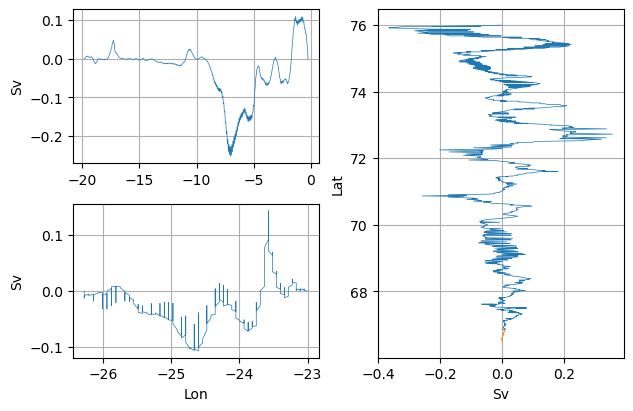

In [46]:
fig, ax = plt.subplot_mosaic([['ul','r'],['ll','r']],
                             figsize=(6.2217,4),layout='constrained')

ax['ul'].plot(north.XC,north,linewidth=0.5)
ax['ul'].grid()
ax['ll'].plot(XC_south,kogur,linewidth=0.5)
ax['ll'].grid()

ax['r'].plot(SB_1,YC_east1,linewidth=0.5)
ax['r'].plot(SB_2,YC_east2,linewidth=0.5)
ax['r'].grid()

ax['ul'].set_ylabel('Sv')
ax['ll'].set_ylabel('Sv')
ax['ll'].set_xlabel('Lon')

ax['r'].set_xlabel('Sv')
ax['r'].set_ylabel('Lat')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/VT_mean',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

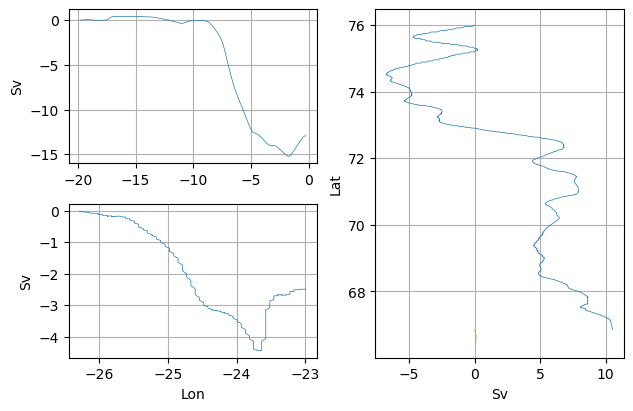

In [47]:
fig, ax = plt.subplot_mosaic([['ul','r'],['ll','r']],
                             figsize=(6.2217,4),layout='constrained')

ax['ul'].plot(north.XC,north.cumsum(dim='mooring'),linewidth=0.5)
ax['ul'].grid()
ax['ll'].plot(XC_south,kogur.cumsum(dim='mooring'),linewidth=0.5)
ax['ll'].grid()

ax['r'].plot(SB_1.cumsum(dim='mooring'),YC_east1,linewidth=0.5)
ax['r'].plot(SB_2.cumsum(dim='mooring'),YC_east2,linewidth=0.5)
ax['r'].grid()

ax['ul'].set_ylabel('Sv')
ax['ll'].set_ylabel('Sv')
ax['ll'].set_xlabel('Lon')

ax['r'].set_xlabel('Sv')
ax['r'].set_ylabel('Lat')

fig.savefig(r'/nird/home/ekv036/MSc/Fig/VT_mean_cum',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)